<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3: Web APIs & NLP

## Background

With the increase in competition in the space for coding bootcamps, example Hack Reactor (online), Vertical Institute, Rocket Academy, Le Wagon, it affects General Assembly's market share and lowers marketing ROI, which in turn leads to General Assembly being unable to hit enrollment KPIs.

GA marketing is therefore trying to figure out how to better identify the online persona of a bootcamp seeker as opposed to that of a computer science major to aid in targeted advertising. Considering the two topics have quite a bit in common, efforts to further segregate the two targets could yield better advertising ROI.

## Problem Statement

Current classifying model using straightforward keywords such as ‘bootcamp’ and ‘coding’ yields around 79% accuracy.

Build a model with >90% accuracy that helps to identify between those who are looking for bootcamp style learning vs computer science majors/prospective students based on the words they use online.

## Data Dictionary:

**Dataset name: data_2**
- Size: 9982 observations, 2 variables
- Description: Final dataset that contains scrapped data from Reddit

|Feature|Type|Dataset|Description|
|:---|:---|:---|:---|
|**subreddit**|*integer*|data|Subreddit categories. 0 refers to csMajors, 1 refers to codingbootcamp| 
|**text**|*string*|data|Posts extracted from csMajor and codingbootcamp subreddit|

## Jupyter Notebook Purpose:
#### Notebook contains codes for:
- API Data Scraping
- Data Cleaning
- Data Preprocessing
- EDA
- Model Selection
- Model Evaluation

#### Summary on:
- Future works
- Conclusion/Recommendation

## Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import nltk
import re
import string
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_auc_score

from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression 

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#change display options
pd.set_option("display.max_rows", 160)
pd.set_option("display.max_columns", 80)

## Scraping Data

In [2]:
# url for API call
url = 'https://api.pushshift.io/reddit/search/submission' 

In [3]:
# defining params
params = {'subreddit': "codingbootcamp", 'size': 100,'before': int(dt.datetime(2022,11,25,23,59).timestamp())}

In [4]:
# submit request to pull data from API
req = requests.get(url, params) 
print(req.status_code)

200


In [5]:
# using json to change it to dict format
data = req.json()

In [6]:
# display info under 1st row, for overview on which information is useful
display(data['data'][0])

{'all_awardings': [],
 'allow_live_comments': False,
 'author': 'FullZenOzeki',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_ssnp2dx2',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1669315434,
 'domain': 'self.codingbootcamp',
 'full_link': 'https://www.reddit.com/r/codingbootcamp/comments/z3rhhr/how_can_i_become_a_coder/',
 'gildings': {},
 'id': 'z3rhhr',
 'is_created_from_ads_ui': False,
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '',
 'link_flair_richtext': [],
 'link_flair_text_color': 'dark',
 'link_flair_type': 'text',
 'locked': False,
 'media_only': False,
 'no_follow': True,
 'num_comments': 0,

#### Automating the scraping process

In [7]:
# automating the scraping process
def datapuller(count,subreddit,before):
    df = pd.DataFrame()
    url = 'https://api.pushshift.io/reddit/search/submission' # url for API call.
    for i in range(count):
        params = {'subreddit': subreddit, 'size': 300,'before': before} #defining params
        req = requests.get(url, params) # Submit request
        data = req.json()
        df = df.append(pd.DataFrame(data['data'])) #Creating dataframe
        df.reset_index(drop=True,inplace = True)
        before = df.loc[len(df)-1,['created_utc']]
    print(f'ping status: {req.status_code}')
    print(f'created_utc: {before}')
    print(f'{len(df)} post scrapped')
    return df

In [8]:
# scrapping from selected subreddits - "autism"
count = 20
subreddit = "codingbootcamp"
before = int(dt.datetime(2022,11,25,23,59).timestamp())
df_1 = datapuller(count,subreddit,before)

ping status: 200
created_utc: created_utc    1525831870
Name: 4989, dtype: object
4990 post scrapped


In [9]:
# scrapping from selected subreddits - ADHD
count = 20
subreddit = "csMajors"
before = int(dt.datetime(2022,11,25,23,59).timestamp())
df_2 = datapuller(count,subreddit,before)

ping status: 200
created_utc: created_utc    1665867967
Name: 4991, dtype: object
4992 post scrapped


## Cleaning Data

#### Cleaning of dataset

In [10]:
# keeping only title,selftext,subreddit columns
df_topic_1 = df_1.loc[:,["subreddit","title","selftext"]]
display(df_topic_1.info())

df_topic_2 = df_2.loc[:,["subreddit","title","selftext"]]
df_topic_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4990 non-null   object
 1   title      4990 non-null   object
 2   selftext   4990 non-null   object
dtypes: object(3)
memory usage: 117.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4992 non-null   object
 1   title      4992 non-null   object
 2   selftext   4986 non-null   object
dtypes: object(3)
memory usage: 117.1+ KB


In [11]:
# replace selftext rows with [removed] comments with ""
for i in range(len(df_topic_1)):
    if df_topic_1.loc[i,"selftext"] == "[removed]":
        df_topic_1.loc[i,"selftext"] = ''
    else:
        continue

df_topic_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4990 non-null   object
 1   title      4990 non-null   object
 2   selftext   4990 non-null   object
dtypes: object(3)
memory usage: 117.1+ KB


In [12]:
#concatenate title and selftext columns:
df_topic_1["text"] = df_topic_1["title"] + " " + df_topic_1["selftext"]

#drop title and selftext columns:
df_topic_1.drop(["title","selftext"],axis = 1, inplace = True)
df_topic_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4990 non-null   object
 1   text       4990 non-null   object
dtypes: object(2)
memory usage: 78.1+ KB


In [13]:
# replace null values with ""
df_topic_2["selftext"].fillna("[removed]", inplace= True)

# replace selftext rows with [removed] comments with ""
for i in range(len(df_topic_2)):
    if df_topic_2.loc[i,"selftext"] == "[removed]":
        df_topic_2.loc[i,"selftext"] = ''
    else:
        continue

df_topic_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4992 non-null   object
 1   title      4992 non-null   object
 2   selftext   4992 non-null   object
dtypes: object(3)
memory usage: 117.1+ KB


In [14]:
#concatenate title and selftext columns:
df_topic_2["text"] = df_topic_2["title"] + " " + df_topic_2["selftext"]

#drop title and selftext columns:
df_topic_2.drop(["title","selftext"],axis = 1, inplace = True)
df_topic_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4992 non-null   object
 1   text       4992 non-null   object
dtypes: object(2)
memory usage: 78.1+ KB


In [15]:
# merging both datasets
data = df_topic_1.append(df_topic_2)
data.reset_index(drop=True,inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9982 non-null   object
 1   text       9982 non-null   object
dtypes: object(2)
memory usage: 156.1+ KB


#### Converting outputs to binary labels

In [16]:
data['subreddit'] = data['subreddit'].map({'codingbootcamp': 1, 'csMajors': 0})
data

,subreddit,text
0,1,How can I become a coder? I hear you cool guys...
1,1,Question How cand I find someone's real adress...
2,1,"Coding made Easyyy!!! Hello, This is your prou..."
3,1,Can you recommend a list of coding bootcamps? ...
4,1,Anyone from Toronto have advice on bootcamp ch...
...,...,...
9977,0,How to prepare for onsite interview? I have a ...
9978,0,I don't have discrete maths? So I am currently...
9979,0,What Companies are hiring for new grads right ...
9980,0,Is USA (University of south Alabama) a bad cho...


In [17]:
#dataset for model training
data = pd.read_csv('../project_3/datasets/data_2.csv')

### Data Dictionary:

**Dataset name: data_2**

|Feature|Type|Dataset|Description|
|:---|:---|:---|:---|
|**subreddit**|*integer*|data|Subreddit categories. 0 refers to csMajors, 1 refers to codingbootcamp| 
|**text**|*string*|data|Posts extracted from csMajor and codingbootcamp subreddit|

## Pre-processing text data

### 1. Remove punctuations

In [18]:
# string.punctuation comprises of a list of all punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

data['text_nostop'] = data['text'].apply(lambda x: remove_punct(x))

data.head()

,subreddit,text,text_nostop
0,1,Anyone from Toronto have advice on bootcamp ch...,Anyone from Toronto have advice on bootcamp ch...
1,1,IronHack vs Le Wagon Helloo!! I‘m looking for ...,IronHack vs Le Wagon Helloo I‘m looking for bo...
2,1,Is an associates degree enough? So I’ve been a...,Is an associates degree enough So I’ve been ac...
3,1,Is freecodingbootcamp.org legit? I mean while ...,Is freecodingbootcamporg legit I mean while it...
4,1,"Artist to Coder, What are my options? Hey guys...",Artist to Coder What are my options Hey guys s...


### 2. Tokenization

In [20]:
def tokenize(text):
    # Matches any character that is neither alphanumeric nor underscore
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text) #split by spaces
    return tokens

data['text_tokenized'] = data['text_nostop'].apply(lambda x: tokenize(x.lower()))

data.head()

,subreddit,text,text_nostop,text_tokenized
0,1,Anyone from Toronto have advice on bootcamp ch...,Anyone from Toronto have advice on bootcamp ch...,"[anyone, from, toronto, have, advice, on, boot..."
1,1,IronHack vs Le Wagon Helloo!! I‘m looking for ...,IronHack vs Le Wagon Helloo I‘m looking for bo...,"[ironhack, vs, le, wagon, helloo, i, m, lookin..."
2,1,Is an associates degree enough? So I’ve been a...,Is an associates degree enough So I’ve been ac...,"[is, an, associates, degree, enough, so, i, ve..."
3,1,Is freecodingbootcamp.org legit? I mean while ...,Is freecodingbootcamporg legit I mean while it...,"[is, freecodingbootcamporg, legit, i, mean, wh..."
4,1,"Artist to Coder, What are my options? Hey guys...",Artist to Coder What are my options Hey guys s...,"[artist, to, coder, what, are, my, options, he..."


### 3. Remove stopwords

In [21]:
# NLTK(Natural Language Toolkit).
stopword = nltk.corpus.stopwords.words('english')

In [22]:
def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

data['text_removestop'] = data['text_tokenized'].apply(lambda x: remove_stopwords(x))

data.head()

,subreddit,text,text_nostop,text_tokenized,text_removestop
0,1,Anyone from Toronto have advice on bootcamp ch...,Anyone from Toronto have advice on bootcamp ch...,"[anyone, from, toronto, have, advice, on, boot...","[anyone, toronto, advice, bootcamp, choice, he..."
1,1,IronHack vs Le Wagon Helloo!! I‘m looking for ...,IronHack vs Le Wagon Helloo I‘m looking for bo...,"[ironhack, vs, le, wagon, helloo, i, m, lookin...","[ironhack, vs, le, wagon, helloo, looking, boo..."
2,1,Is an associates degree enough? So I’ve been a...,Is an associates degree enough So I’ve been ac...,"[is, an, associates, degree, enough, so, i, ve...","[associates, degree, enough, accepted, local, ..."
3,1,Is freecodingbootcamp.org legit? I mean while ...,Is freecodingbootcamporg legit I mean while it...,"[is, freecodingbootcamporg, legit, i, mean, wh...","[freecodingbootcamporg, legit, mean, sound, go..."
4,1,"Artist to Coder, What are my options? Hey guys...",Artist to Coder What are my options Hey guys s...,"[artist, to, coder, what, are, my, options, he...","[artist, coder, options, hey, guys, holding, o..."


### 4. Stemming/Lemmatizing

#### Stemming

In [23]:
ps = nltk.PorterStemmer()

In [24]:
def stemming(tokenized_text):
    # return list of all stemmed words for their corresponding words in tokenized_text
    text = [ps.stem(word) for word in tokenized_text]
    return text

data['text_stemmed'] = data['text_removestop'].apply(lambda x: stemming(x))

data.head()

,subreddit,text,text_nostop,text_tokenized,text_removestop,text_stemmed
0,1,Anyone from Toronto have advice on bootcamp ch...,Anyone from Toronto have advice on bootcamp ch...,"[anyone, from, toronto, have, advice, on, boot...","[anyone, toronto, advice, bootcamp, choice, he...","[anyon, toronto, advic, bootcamp, choic, hello..."
1,1,IronHack vs Le Wagon Helloo!! I‘m looking for ...,IronHack vs Le Wagon Helloo I‘m looking for bo...,"[ironhack, vs, le, wagon, helloo, i, m, lookin...","[ironhack, vs, le, wagon, helloo, looking, boo...","[ironhack, vs, le, wagon, helloo, look, bootca..."
2,1,Is an associates degree enough? So I’ve been a...,Is an associates degree enough So I’ve been ac...,"[is, an, associates, degree, enough, so, i, ve...","[associates, degree, enough, accepted, local, ...","[associ, degre, enough, accept, local, colleg,..."
3,1,Is freecodingbootcamp.org legit? I mean while ...,Is freecodingbootcamporg legit I mean while it...,"[is, freecodingbootcamporg, legit, i, mean, wh...","[freecodingbootcamporg, legit, mean, sound, go...","[freecodingbootcamporg, legit, mean, sound, go..."
4,1,"Artist to Coder, What are my options? Hey guys...",Artist to Coder What are my options Hey guys s...,"[artist, to, coder, what, are, my, options, he...","[artist, coder, options, hey, guys, holding, o...","[artist, coder, option, hey, guy, hold, onto, ..."


#### Lemmatizing

In [25]:
wn = nltk.WordNetLemmatizer()

In [26]:
def lemmatizing(tokenized_text):
    # return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

data['text_lemmatized'] = data['text_removestop'].apply(lambda x: lemmatizing(x))

data.head(10)

,subreddit,text,text_nostop,text_tokenized,text_removestop,text_stemmed,text_lemmatized
0,1,Anyone from Toronto have advice on bootcamp ch...,Anyone from Toronto have advice on bootcamp ch...,"[anyone, from, toronto, have, advice, on, boot...","[anyone, toronto, advice, bootcamp, choice, he...","[anyon, toronto, advic, bootcamp, choic, hello...","[anyone, toronto, advice, bootcamp, choice, he..."
1,1,IronHack vs Le Wagon Helloo!! I‘m looking for ...,IronHack vs Le Wagon Helloo I‘m looking for bo...,"[ironhack, vs, le, wagon, helloo, i, m, lookin...","[ironhack, vs, le, wagon, helloo, looking, boo...","[ironhack, vs, le, wagon, helloo, look, bootca...","[ironhack, v, le, wagon, helloo, looking, boot..."
2,1,Is an associates degree enough? So I’ve been a...,Is an associates degree enough So I’ve been ac...,"[is, an, associates, degree, enough, so, i, ve...","[associates, degree, enough, accepted, local, ...","[associ, degre, enough, accept, local, colleg,...","[associate, degree, enough, accepted, local, c..."
3,1,Is freecodingbootcamp.org legit? I mean while ...,Is freecodingbootcamporg legit I mean while it...,"[is, freecodingbootcamporg, legit, i, mean, wh...","[freecodingbootcamporg, legit, mean, sound, go...","[freecodingbootcamporg, legit, mean, sound, go...","[freecodingbootcamporg, legit, mean, sound, go..."
4,1,"Artist to Coder, What are my options? Hey guys...",Artist to Coder What are my options Hey guys s...,"[artist, to, coder, what, are, my, options, he...","[artist, coder, options, hey, guys, holding, o...","[artist, coder, option, hey, guy, hold, onto, ...","[artist, coder, option, hey, guy, holding, ont..."
5,1,Highest Paying Programming Languages,Highest Paying Programming Languages,"[highest, paying, programming, languages, ]","[highest, paying, programming, languages, ]","[highest, pay, program, languag, ]","[highest, paying, programming, language, ]"
6,1,"Entry Level Developer Salary Hey everyone, is ...",Entry Level Developer Salary Hey everyone is t...,"[entry, level, developer, salary, hey, everyon...","[entry, level, developer, salary, hey, everyon...","[entri, level, develop, salari, hey, everyon, ...","[entry, level, developer, salary, hey, everyon..."
7,1,Navy Vet (using VETTEC) and trying to decide b...,Navy Vet using VETTEC and trying to decide bet...,"[navy, vet, using, vettec, and, trying, to, de...","[navy, vet, using, vettec, trying, decide, cod...","[navi, vet, use, vettec, tri, decid, code, boo...","[navy, vet, using, vettec, trying, decide, cod..."
8,1,Tech Talent South I am currently working as a ...,Tech Talent South I am currently working as a ...,"[tech, talent, south, i, am, currently, workin...","[tech, talent, south, currently, working, busi...","[tech, talent, south, current, work, busi, ana...","[tech, talent, south, currently, working, busi..."
9,1,Digital Crafts structure Hey everyone! I've ha...,Digital Crafts structure Hey everyone Ive had ...,"[digital, crafts, structure, hey, everyone, iv...","[digital, crafts, structure, hey, everyone, iv...","[digit, craft, structur, hey, everyon, ive, lo...","[digital, craft, structure, hey, everyone, ive..."


## EDA

Text(0.5, 1.0, 'Counts of subreddit')

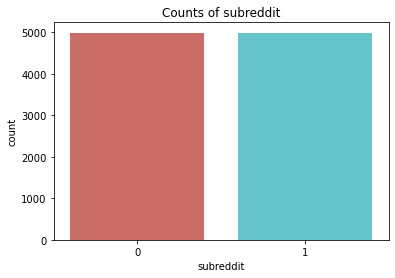

In [27]:
# Plotting counts of subreddit databootcamp and csMajors
sb.countplot(x='subreddit', data=data, palette='hls')
plt.title("Counts of subreddit")

#### Legend: 
- 0: csMajor 
- 1: codingbootcamp

#### Comments:

- There are only 2 classes for target variable, suitable data set for logistic regression, Bernoulli Naive Bayes and Multinomial Naive Bayes models. 
- Multinomial Naive Bayes model is more suitable for features which are positive. With the classification of target to binary(0,1) form, it allows for this model to be a suitable classification model.  

#### Finding additional stopwords

In [28]:
# function to remove punctuation, tokenize, remove stopwords and lemmatize
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply lemmatizing and stopwords exclusion within the same step
    text = [wn.lemmatize(word) for word in tokens if word not in stopword]
    
    return text

In [29]:
# Create an instance of CountVectorizer
cv = CountVectorizer(analyzer=clean_text)

In [30]:
X = data["text"]
y = data["subreddit"]

In [31]:
# transform and fit X_train
X_stopword = cv.fit_transform(X)

In [32]:
# Convert vector to dataframe format
X_stopword_df = pd.DataFrame(X_stopword.toarray())
X_stopword_df.columns = cv.get_feature_names()
X_stopword_df.head()

,,0,000,0000ff,000webhost,001,001f,005f,01,010,010f,011,012,012323,02,020,025,025f,03062022,0315,04,0415,05,06000,0719,08,0901,0905,0908,0909,0919,09212021,0930,0lttlt1,1,10,100,1000,10000,100000,...,yus,yyyymonth,z,zak,zalgorithm,zapier,zbook,zed,zelda,zendesk,zero,zeroed,zillow,zip,zipline,ziprecruiter,zksync,zocdoc,zomato,zombie,zon,zone,zoning,zoom,zoomkerg,zoox,zpetv2,zurich,zybooks,zyvo,½,άλλο,για,και,μηδεν,π,τιμη,το,ｃｒｅａｔｅ,ｉｍａｇｉｎｅ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
#Merging sub-reddit category to dataframe:
X_stopword_df["target"] = y.values

In [34]:
# codingbootcamp:
X_stopword_df_1 = X_stopword_df[X_stopword_df["target"] == 1]
X_stopword_df_1.drop(["target"], axis = 1, inplace = True)
X_stopword_df_1.sum().sort_values(ascending=False).head(50)

bootcamp      3391
coding        2749
job           2117
              1895
would         1813
get           1696
im            1690
like          1577
time          1541
know          1314
experience    1233
camp          1220
anyone        1214
program       1188
course        1162
one           1131
want          1121
boot          1083
work          1047
learn         1043
help          1030
looking       1012
bootcamps      972
year           931
good           882
code           837
career         830
really         819
week           814
also           805
people         805
learning       795
need           773
ive            743
start          706
make           701
month          700
question       685
software       665
dont           659
go             651
degree         635
python         631
project        627
tech           626
full           604
free           598
academy        590
much           586
lot            585
dtype: int64

In [35]:
# csMajor:
X_stopword_df_0 = X_stopword_df[X_stopword_df["target"] == 0]
X_stopword_df_0.drop(["target"], axis = 1, inplace = True)
X_stopword_df_0.sum().sort_values(ascending=False).head(50)

interview     2334
internship    2163
offer         1662
anyone        1421
company       1373
would         1272
get           1242
im            1204
like          1161
intern        1096
              1061
know          1047
question       997
got            987
c              942
swe            928
time           917
one            896
year           852
summer         783
round          724
job            701
new            658
back           656
also           646
oa             643
experience     640
week           623
really         617
final          615
good           609
grad           598
want           597
work           587
view           551
take           523
next           523
first          521
people         495
recruiter      492
think          484
project        479
dont           474
2              472
even           471
much           464
2023           463
resume         454
technical      444
class          443
dtype: int64

- Additional stopwords: "want","one","anyone","like","im","get","would","got","really","also",'ive','know','dont','go','much','lot','take','think','even','getting','back',""

### Count Vectorizer

In [36]:
# adding more stopwords
add_stopword = stopword + ["want","one","anyone","like","im","get","would","got"] + ['really','also','ive','know','dont','go','much','lot','take','think','even','getting','back',""]

In [37]:
# function to remove punctuation, tokenize, remove stopwords and lemmatize
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in add_stopword]
    return text

In [38]:
# Create an instance of CountVectorizer
cv = CountVectorizer(analyzer=clean_text)

In [39]:
# transform and fit X_train
X_cv = cv.fit_transform(X)

In [40]:
# Returns the number of rows and columns of X_train
print(X_cv.shape)

(9982, 19305)


- X_cv has 19,305 unique words

In [41]:
# Convert vector to dataframe format
X_cv_df = pd.DataFrame(X_cv.toarray())
X_cv_df.columns = cv.get_feature_names()

In [42]:
#Merging sub-reddit category to dataframe:
X_cv_df["target"] = y.values

Text(0, 0.5, 'Keywords')

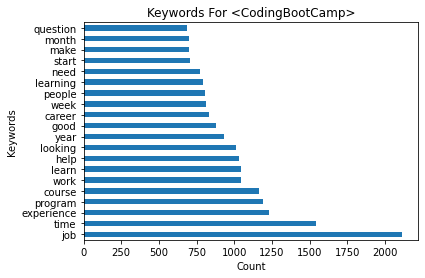

In [43]:
# codingbootcamp:
X_cv_df_1 = X_cv_df[X_cv_df["target"] == 1]
# exclude "target","bootcamp","bootcamps","boot","camp","coding","code", to find out what other keywords there are.
X_cv_df_1.drop(["target","bootcamp","bootcamps","boot","camp","coding","code"], axis = 1, inplace = True)
X_cv_df_1.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Keywords For <CodingBootCamp>")
plt.xlabel("Count")
plt.ylabel("Keywords")

Text(0, 0.5, 'Keywords')

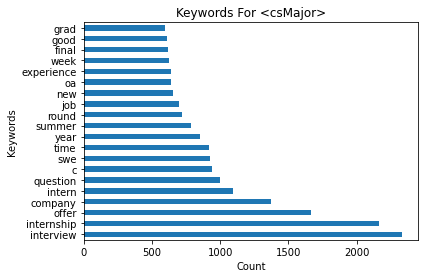

In [44]:
# csMajor:
X_cv_df_0 = X_cv_df[X_cv_df["target"] == 0]
X_cv_df_0.drop(["target"], axis = 1, inplace = True)
X_cv_df_0.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Keywords For <csMajor>")
plt.xlabel("Count")
plt.ylabel("Keywords")

#### Interpretation of keywords: 
- Some keywords that showed up for codingbootcamp (excluding "target","bootcamp","bootcamps","boot","camp","coding","code") were job, work, career. This is indicative that people who are interested in bootcamp, are usually more to find out what job opportunities that they will have, after completing the boot camp.
- Some keywords that showed up for csMajor were "internship", "offer", "company", "summer". That is indicative that computer science students tend to be more interested or on the look out for internship opportunities to gain experience during their course of study in the university, prior to entering the working world, as opposed to students in data bootcamps. 

### N-Grams

In [45]:
# Breaking down into smaller sample sets 
# csMajors
data_sample_cs = data[4991:6991]

# codingbootcamp
data_sample_bc = data[0:2000]

add_stopword_ngram = stopword + ["want","one","anyone","like","im","get","would","got"] + ['really','also','ive','know','dont','go','much','lot','take','think','even','getting','back',""] + ["bootcamp","bootcamps","boot","camp","camps","coding","code"]

In [46]:
def clean_text_ngram(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in add_stopword_ngram])
    return text

#### csMajors Dataset

In [47]:
# cleaning csMajors dataset 
data_sample_cs['cleaned_text'] = data_sample_cs["text"].apply(lambda x: clean_text_ngram(x))
data_sample_cs.loc[:,["subreddit","text","cleaned_text"]]

,subreddit,text,cleaned_text
4991,0,Is it normal to apply for multiple different p...,normal apply multiple different position big c...
4992,0,Google STEP/Microsoft Explore with no experien...,google stepmicrosoft explore experience big te...
4993,0,Expedia New Grad Final Round Has anyone done t...,expedia new grad final round done final round ...
4994,0,"Multimedia, fileformats and compression https:...",multimedia fileformats compression httpsstudie...
4995,0,Been 1 month since LinkedIn final and still no...,1 month since linkedin final still decision fi...
...,...,...,...
6986,0,how hard will it be to find an internship in m...,hard find internship junior year cant find yea...
6987,0,Amazon New Grad EMEA,amazon new grad emea
6988,0,CS vs CE I was initially planning on majoring ...,c v ce initially planning majoring form engine...
6989,0,Has anyone received summer housing info or any...,received summer housing info info internship s...


In [48]:
# ngram fit/transform for csMajors dataset:
ngram_vect_1 = CountVectorizer(ngram_range=(1,1)) 
X_ngram_1_cs = ngram_vect_1.fit_transform(data_sample_cs['cleaned_text'])

ngram_vect_2 = CountVectorizer(ngram_range=(2,2))
X_ngram_2_cs = ngram_vect_2.fit_transform(data_sample_cs["cleaned_text"])

ngram_vect_3 = CountVectorizer(ngram_range=(3,3)) 
X_ngram_3_cs = ngram_vect_3.fit_transform(data_sample_cs['cleaned_text'])

In [49]:
print(X_ngram_1_cs.shape)
print(X_ngram_2_cs.shape)
print(X_ngram_3_cs.shape)

(2000, 7268)
(2000, 45959)
(2000, 54529)


##### csMajor sample dataset contains:
- Data Set has 7,272 unique 1-word combinations
- Data Set has 46,118 unique 2-word combinations
- Data Set has 54,758 unique 3-word combinations

In [50]:
# convert to dataframe format
X_ngram_1_cs_df = pd.DataFrame(X_ngram_1_cs.toarray())
X_ngram_1_cs_df.columns = ngram_vect_1.get_feature_names()

X_ngram_2_cs_df = pd.DataFrame(X_ngram_2_cs.toarray())
X_ngram_2_cs_df.columns = ngram_vect_2.get_feature_names()

X_ngram_3_cs_df = pd.DataFrame(X_ngram_3_cs.toarray())
X_ngram_3_cs_df.columns = ngram_vect_3.get_feature_names()

Text(0, 0.5, 'Keywords')

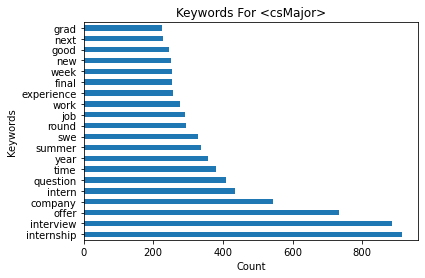

In [51]:
# Word count plots for csMajor single-gram (1,1)
X_ngram_1_cs_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Keywords For <csMajor>")
plt.xlabel("Count")
plt.ylabel("Keywords")

Text(0, 0.5, 'Keywords')

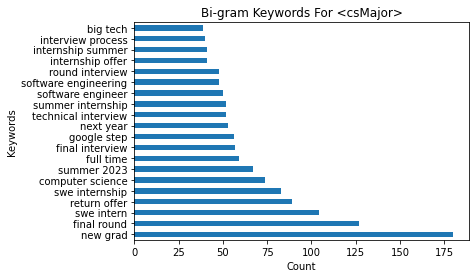

In [52]:
# Word count plots for csMajor Bi-gram (2,2):
X_ngram_2_cs_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Bi-gram Keywords For <csMajor>")
plt.xlabel("Count")
plt.ylabel("Keywords")

Text(0, 0.5, 'Keywords')

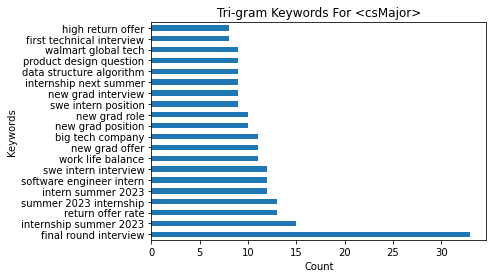

In [53]:
# Word count plots for csMajor Tri-gram (3,3):
X_ngram_3_cs_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Tri-gram Keywords For <csMajor>")
plt.xlabel("Count")
plt.ylabel("Keywords")

#### Interpretation of keywords for csMajor:
##### Unigram
- Some keywords that showed up for csMajor uni-gram were "internship", "offer", "company", "summer". That is indicative that computer science students tend to be more interested or on the look out for internship opportunities to gain experience during their course of study in the university, prior to entering the working world, as opposed to students in data bootcamps.
- "swe" which means software engineer also shows up often indicating that computer science students are usually interested in sotware engineering roles

##### Bi-gram
- Terms like "swe internship","swe intern", "summer internship", "software engineer" shows that computer science students are usually interested in software engineering role, and are open to take up internships during their summer vacations.

##### Tri-gram
- Similar terms related to software engineering internship role appear often (e.g. "internship summer 2023", "summer 2023 internship", "software engineer intern", "swe intern position"), other terms like final round interview also shows up, which is indicative that CS students show strong interest in what prospective companies might ask in their final interview rounds. 
- Other terms like "big tech company" and "walmart global tech" are also observed, which can be interpreted as CS students showing strong interest in the tech industry.

#### Codingbootcamp dataset

In [54]:
# cleaning codingbootcamp dataset 
data_sample_bc['cleaned_text'] = data_sample_bc["text"].apply(lambda x: clean_text_ngram(x))
data_sample_bc.loc[:,["subreddit","text","cleaned_text"]]

,subreddit,text,cleaned_text
0,1,Anyone from Toronto have advice on bootcamp ch...,toronto advice choice hello human biology grad...
1,1,IronHack vs Le Wagon Helloo!! I‘m looking for ...,ironhack v le wagon helloo looking best two op...
2,1,Is an associates degree enough? So I’ve been a...,associate degree enough accepted local college...
3,1,Is freecodingbootcamp.org legit? I mean while ...,freecodingbootcamporg legit mean sound good tr...
4,1,"Artist to Coder, What are my options? Hey guys...",artist coder option hey guy holding onto idea ...
...,...,...,...
1995,1,Looking into a different bootcamp So I was wor...,looking different working prep course springbo...
1996,1,Financial Assistance for Bootcamp I've been ac...,financial assistance accepted turing denver co...
1997,1,Claiming tax credit for bootcamp tuition Hi gu...,claiming tax credit tuition hi guy last year a...
1998,1,If the ‘Hello’ in ‘Hello World’ is twice the s...,hello hello world twice size world world show ...


In [55]:
# ngram fit/transform for csMajors dataset:
ngram_vect_1 = CountVectorizer(ngram_range=(1,1)) 
X_ngram_1_bc = ngram_vect_1.fit_transform(data_sample_bc['cleaned_text'])

ngram_vect_2 = CountVectorizer(ngram_range=(2,2))
X_ngram_2_bc = ngram_vect_2.fit_transform(data_sample_bc["cleaned_text"])

ngram_vect_3 = CountVectorizer(ngram_range=(3,3)) 
X_ngram_3_bc = ngram_vect_3.fit_transform(data_sample_bc['cleaned_text'])

In [56]:
print(X_ngram_1_bc.shape)
print(X_ngram_2_bc.shape)
print(X_ngram_3_bc.shape)

(2000, 8156)
(2000, 59641)
(2000, 71162)


##### codingbootcamp sample dataset contains:
- Data Set has 8,161 unique 1-word combinations
- Data Set has 60,525 unique 2-word combinations
- Data Set has 74,427 unique 3-word combinations

In [57]:
# convert to dataframe format
X_ngram_1_bc_df = pd.DataFrame(X_ngram_1_bc.toarray())
X_ngram_1_bc_df.columns = ngram_vect_1.get_feature_names()

X_ngram_2_bc_df = pd.DataFrame(X_ngram_2_bc.toarray())
X_ngram_2_bc_df.columns = ngram_vect_2.get_feature_names()

X_ngram_3_bc_df = pd.DataFrame(X_ngram_3_bc.toarray())
X_ngram_3_bc_df.columns = ngram_vect_3.get_feature_names()

Text(0, 0.5, 'Keywords')

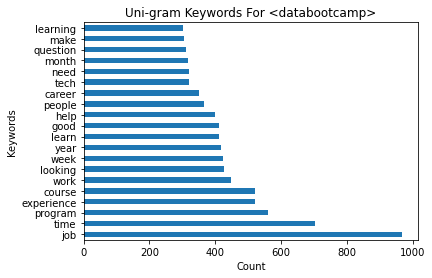

In [58]:
# Word count plots for databootcamp single-gram (1,1)
X_ngram_1_bc_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Uni-gram Keywords For <databootcamp>")
plt.xlabel("Count")
plt.ylabel("Keywords")

Text(0, 0.5, 'Keywords')

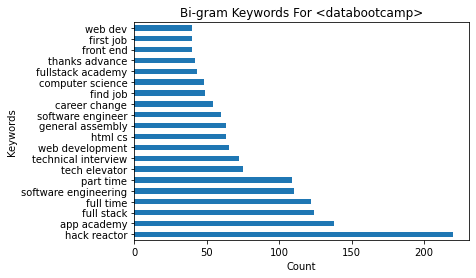

In [59]:
# Word count plots for databootcamp bi-gram (2,2)
X_ngram_2_bc_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Bi-gram Keywords For <databootcamp>")
plt.xlabel("Count")
plt.ylabel("Keywords")

Text(0, 0.5, 'Keywords')

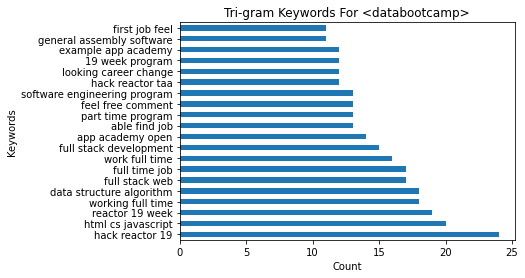

In [60]:
# Word count plots for databootcamp tri-gram (3,3)
X_ngram_3_bc_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Tri-gram Keywords For <databootcamp>")
plt.xlabel("Count")
plt.ylabel("Keywords")

#### Interpretation of keywords for codingbootcamp:
##### Unigram
- Some keywords that showed up for codingbootcamp (excluding "target","bootcamp","bootcamps","boot","camp","coding","code") were job, work, career. This is indicative that people who are interested in bootcamp, are usually more to find out what job opportunities that they will have, after completing the boot camp.

##### Bi-gram
- "hack reactor", "app academy", "general assembly", "tech elevator" are all coding boot camp schools appearing in the top 20 words. Shows the prospective student's interest in bootcamps.

##### Tri-gram
- Terms like "reactor 19 week" shows up, which could be indicative that prospective data boot camp students are looking for a short term course (unlike a university degree), to enable them to start working as soon as possible.
- Terms like "working full time", "full time job", "able find job" can be interpreted as prospective data boot camp students prioritize being able to get a full time job subsequently after they complete the course
- Other tri-gram words appear as well, such as "html cs javascript", "full stack web", could be indicative that bootcamp students are looking for these technical skillsets which are highly regarded by the industry.

### TF-IDF (Term Frequency - Inverse Document Frequency)

In [61]:
tfidf = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf.fit_transform(data['text'])

In [62]:
print(X_tfidf.shape)

(9982, 19305)


- Data Set has 19419 unique words, same as count vectorizer

In [63]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf.get_feature_names()

In [64]:
#Merging sub-reddit category to dataframe:
X_tfidf_df["target"] = y.values

<AxesSubplot:>

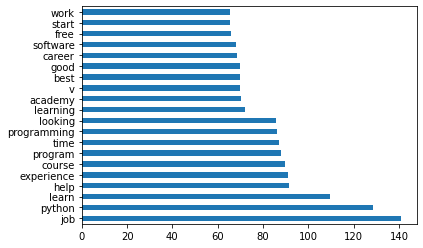

In [65]:
# codingbootcamp:
X_tfidf_df_1 = X_tfidf_df[X_tfidf_df["target"] == 1]
X_tfidf_df_1.drop(["target","bootcamp","bootcamps","boot","camp","coding","code"], axis = 1, inplace = True)
X_tfidf_df_1.sum().sort_values(ascending=False).head(20).plot(kind='barh')

<AxesSubplot:>

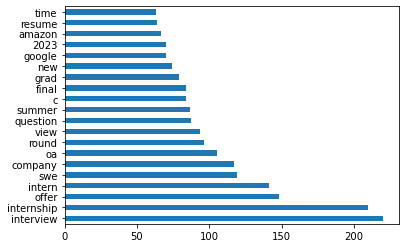

In [66]:
# csMajor:
X_tfidf_df_0 = X_tfidf_df[X_tfidf_df["target"] == 0]
X_tfidf_df_0.drop(["target"], axis = 1, inplace = True)
X_tfidf_df_0.sum().sort_values(ascending=False).head(20).plot(kind='barh')

#### Interpretation of keywords from TF-IDF:
- Similar conclusion to count vectorization

## Modeling

### Setting Up Data For Modeling

In [67]:
X = data["text"]
y = data["subreddit"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

### Pipelines Accuracy Comparison

Setup various vectorizing + model pipelines in the following 3 jupyter notebooks:
- code-countvectorizing
- code-Ngram
- code-TF-IDF

Incorporated grid-search for each pipelines, to tune and obtain most optimal hyperparameter values to achieve highest accuracy scores.

#### Results from the respective pipelines:

|**Vectorization Method**|**Model**|**Train Results**|**Test Results**|
|:---|:---|:---:|:---:|
|Count Vectorizer|Naive Bayes - Bernoulli|0.84611|0.84215|
|Count Vectorizer|Naive Bayes - Multinomial|0.93214|0.93149|
|Count Vectorizer|Logistic Regression|0.98678|0.93429|
|Count Vectorizer|K-Nearest Neighbours|0.90489|0.83694|
|Bi-Gram|Naive Bayes - Bernoulli|0.90435|0.86057|
|Bi-Gram|Naive Bayes - Multinomial|0.98464|0.90545|
|Bi-Gram|Logistic Regression|0.94416|0.875|
|Bi-Gram|K-Nearest Neighbours|0.78987|0.61218|
|Tri-Gram|Naive Bayes - Bernoulli|0.96874|0.76883|
|Tri-Gram|Naive Bayes - Multinomial|0.96954|0.77484|
|Tri-Gram|Logistic Regression|0.88204|0.71834|
|TF-IDF|Naive Bayes - Bernoulli|0.95698|0.92548|
|TF-IDF|Naive Bayes - Multinomial|0.95431|0.92748|
|TF-IDF|Logistic Regression|0.96193|0.94231|
|TF-IDF|K-Nearest Neighbours|0.86762|0.87260|

- Pipeline with the best train-test R2 scores: TF-IDF + Logistic Regression model. (0.96193/0.94231)
- Subsequent model evaluation will focus on this model

#### TF-IDF + Logistic Regression 

In [69]:
# Setting up pipeline with 2 stages:
# 1. TF-IDF (transformer) + clean text
# 2. Logistic Regression (estimator)

pipe_tf_lg = Pipeline([
    ("tf", TfidfVectorizer(analyzer=clean_text)),
    ('lg', LogisticRegression(solver='liblinear'))
])

In [70]:
#hyperparameter tuning
params_tf_lg = {
    'tf__max_features': [13_000],
    'tf__min_df': [1],
    'tf__max_df': [0.4],
    'lg__solver': ["saga"]
}

In [71]:
# Instantiate GridSearchCV
gs_tf_lg = GridSearchCV(pipe_tf_lg, # what object are we optimizing?
                  param_grid=params_tf_lg, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [72]:
# Fit GridSearch to training data.
gs_tf_lg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(analyzer=<function clean_text at 0x000001408EC4FC10>)),
                                       ('lg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'lg__solver': ['saga'], 'tf__max_df': [0.4],
                         'tf__max_features': [13000], 'tf__min_df': [1]})

In [73]:
# Best score: Mean cross-validated score of the best_estimator (we did a cv = 5)
print(f'best cross validation score: {gs_tf_lg.best_score_}') 

# Score model on training set.
print(f'score on train set: {gs_tf_lg.score(X_train, y_train)}')

# Score model on testing set.
print(f'score on test set: {gs_tf_lg.score(X_test, y_test)}')

best cross validation score: 0.9273305846227391
score on train set: 0.962463264760887
score on test set: 0.9423076923076923


- best cross validation score: 0.9270633835539348
- score on train set: 0.9619289340101523
- score on test set: 0.9423076923076923

#### Baseline Model

- Baseline model uses the following keywords to identify people who are interested in coding boot camps: baseline_model_words = "bootcamp","bootcamps","boot","camp","camps","coding","code"

In [74]:
baseline_model_words = ["bootcamp","bootcamps","boot","camp","camps","coding","code"]

In [75]:
def baseline_model(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word in baseline_model_words]
    
    return text

In [76]:
# Setting up pipeline with 2 stages:
# 1. TF-IDF (transformer) + clean text
# 2. Logistic Regression (estimator)

pipe_baseline = Pipeline([
    ("tf", TfidfVectorizer(analyzer=baseline_model)),
    ('lg', LogisticRegression(solver='liblinear'))
])

In [77]:
#hyperparameter tuning
params_baseline_tf_lg = {'tf__max_features': [None],
    'tf__min_df': [1],
    'tf__max_df': [1.0]
}

In [78]:
# Instantiate GridSearchCV
gs_baseline = GridSearchCV(pipe_baseline, # what object are we optimizing?
                  param_grid=params_baseline_tf_lg, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [79]:
# Fit GridSearch to training data.
gs_baseline.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(analyzer=<function baseline_model at 0x00000140EEA42550>)),
                                       ('lg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'tf__max_df': [1.0], 'tf__max_features': [None],
                         'tf__min_df': [1]})

In [80]:
# Best score: Mean cross-validated score of the best_estimator (we did a cv = 5)
print(f'best cross validation score: {gs_baseline.best_score_}') 

# Score model on training set.
print(f'score on train set: {gs_baseline.score(X_train, y_train)}')

# Score model on testing set.
print(f'score on test set: {gs_baseline.score(X_test, y_test)}')

best cross validation score: 0.7803878339678914
score on train set: 0.7803900614480364
score on test set: 0.7864583333333334


- best cross validation score: 0.7803878339678914
- score on train set: 0.7803900614480364
- score on test set: 0.7864583333333334

## Model Evaluation

#### Confusion Matrix

In [81]:
# Display Classification Metrics
# TF-IDF + Logistic Regression
y_pred_tf_lg = gs_tf_lg.predict(X_test)
print(confusion_matrix(y_test, y_pred_tf_lg))

# Baseline Model
y_pred_baseline = gs_baseline.predict(X_test)
print(confusion_matrix(y_test, y_pred_baseline))

[[1165   83]
 [  61 1187]]
[[1164   84]
 [ 449  799]]


#### Confusion Matrix + Accuracy heatmap plot

In [82]:
# Create modified labels for Confusion Matrix for TF-IDF + Log Regression
modified_cm_lg = []
for index,value in enumerate(confusion_matrix(y_test, y_pred_tf_lg)):
    if index == 0:
        modified_cm_lg.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm_lg.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])  
        
# Create modified labels for Confusion Matrix for baseline
modified_cm_baseline = []
for index,value in enumerate(confusion_matrix(y_test, y_pred_baseline)):
    if index == 0:
        modified_cm_baseline.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm_baseline.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])  

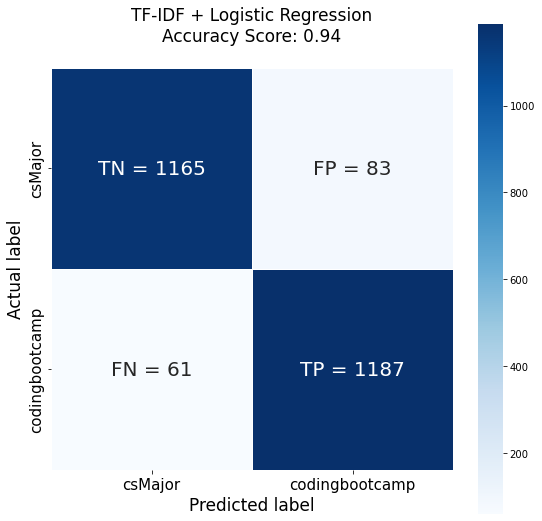

In [83]:
# TF-IDF + Log Regression
plt.figure(figsize=(9,9))
sb.heatmap((confusion_matrix(y_test, y_pred_tf_lg)), annot=np.array(modified_cm_lg),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['csMajor', 'codingbootcamp'],
            yticklabels = ['csMajor', 'codingbootcamp'],
            );

score = gs_tf_lg.score(X_test, y_test)
plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title("TF-IDF + Logistic Regression" + "\n"+ 'Accuracy Score: {:.2f}'.format(score) + "\n", size = 17);
plt.tick_params(labelsize= 15)

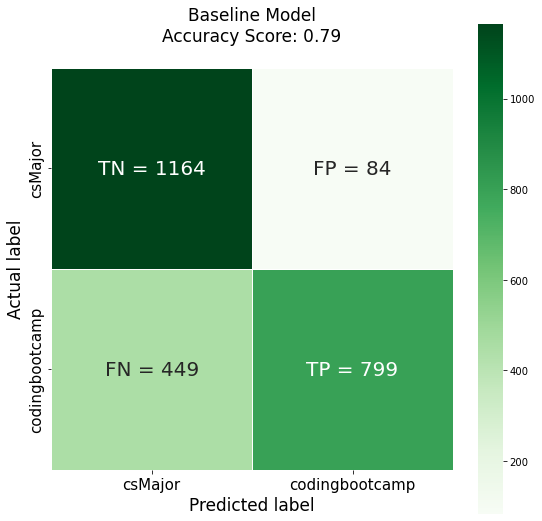

In [84]:
# Baseline Model
plt.figure(figsize=(9,9))
sb.heatmap((confusion_matrix(y_test, y_pred_baseline)), annot=np.array(modified_cm_baseline),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Greens',
            xticklabels = ['csMajor', 'codingbootcamp'],
            yticklabels = ['csMajor', 'codingbootcamp'],
            );

score = gs_baseline.score(X_test, y_test)
plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title("Baseline Model" + "\n" +
    'Accuracy Score: {:.2f}'.format(score)+ "\n", size = 17);
plt.tick_params(labelsize= 15)

* TN = `confusion_matrix[0][0]` (Predict correctly + Prediction was 'csMajor') 
* FP = `confusion_matrix[0][1]` (Predict wrongly + Prediction was 'codingbootcamp')
* FN = `confusion_matrix[1][0]` (Predict wrongly + Prediction was 'csMajor')
* TP = `confusion_matrix[1][1]` (Predict correctly + Prediction was 'codingbootcamp')

#### Comments on Confusion Matrix:
- TN: True Negative, TP: True Positive → Predictions are correct, for either classes
- FN: False Negative, FP: False Positive → Predictions are wrong, for either classes
- Positive class: codingbootcamp, Negative class: csMajor.
- Accuracy = True Predictions / Total Predictions.
- Better accuracy for TF-IDF + logistic regression model.

#### Classification Report

In [85]:
#Classification report for "TF-IDF + Logistic Regression"
print("TF-IDF + Logistic Regression")
print(classification_report(y_test, y_pred_tf_lg, target_names=["csMajor","codingbootcamp"]))

TF-IDF + Logistic Regression
                precision    recall  f1-score   support

       csMajor       0.95      0.93      0.94      1248
codingbootcamp       0.93      0.95      0.94      1248

      accuracy                           0.94      2496
     macro avg       0.94      0.94      0.94      2496
  weighted avg       0.94      0.94      0.94      2496



In [86]:
#Classification report for "Baseline Model"
print("Baseline")
print(classification_report(y_test, y_pred_baseline,target_names=["csMajor","codingbootcamp"]))

Baseline
                precision    recall  f1-score   support

       csMajor       0.72      0.93      0.81      1248
codingbootcamp       0.90      0.64      0.75      1248

      accuracy                           0.79      2496
     macro avg       0.81      0.79      0.78      2496
  weighted avg       0.81      0.79      0.78      2496



#### _Recap on Classification Metrics Formula_
* Accuracy = True Predictions / Total Predictions
* Precision = True Positives / (True Positives + False Positives)
* Recall = True Positives / (True Positives + False Negatives)
* F1-Score  = Weighted Average of Precision and Recall
    * Offers a better overall measure of performance
* Support = True Positives (or True Negatives) that lie in that class

#### Comments on classification report:
- Using the TP/TN/FP/FN values from the confusion matrix, we can further calculate the precision, recall, f1-scores, which are other factors which offers us a better overall measure of the model’s performance on top of accuracy.
- In this case the F1 score for TF-IDF + Logistic Regression is 0.94, which is much higher in comparison to baseline model of ~0.78.

#### Receiver Operating Characteristic (ROC) Curve

Text(0.5, 1.0, 'TF-IDF + Logistic Regression\n')

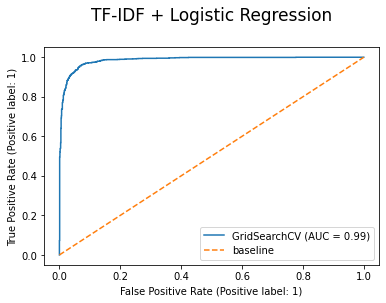

In [87]:
plot_roc_curve(gs_tf_lg, X_test, y_test)

plt.plot([0, 1],  [0, 1],
         label='baseline', linestyle='--')
plt.legend();
plt.title("TF-IDF + Logistic Regression" + "\n", size = 17)

In [88]:
roc_auc_score(y_test, gs_tf_lg.predict_proba(X_test)[:,1])

0.9856764412804075

Text(0.5, 1.0, 'Baseline\n')

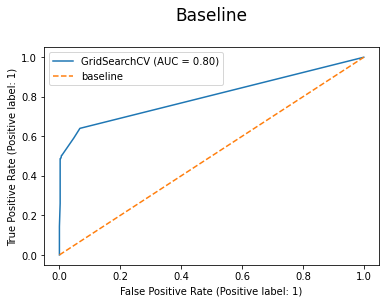

In [89]:
plot_roc_curve(gs_baseline, X_test, y_test)

plt.plot([0, 1],  [0, 1],
         label='baseline', linestyle='--')
plt.legend();
plt.title("Baseline" + "\n", size = 17)

In [90]:
roc_auc_score(y_test, gs_baseline.predict_proba(X_test)[:,1])

0.8020046818499343

#### Comments on ROC curve:
- The ROC curve or the Receiver Operating Characteristic Curve, plots the True Positive Rate against the False positive rate. 
- The Area under the ROC (AUC) curve gives us an idea of how well the model does in terms of predicting or classifying the target value.
- TF-IDF + Logistic Regression model has a high ROC AUC score of ~0.985 (close to 1). This means that the 1 and 0 populations are perfectly separated, and the model is capable of differentiating between both subreddits categories.
- In this case, we can see from the baseline model that the AUC is ~0.8, while the TF-IDF + logistic regression model has an AUC of ~0.99. Hence there is a big improvement in differentiating and classifying which sub-reddit post belongs to.

## Top Features For Model

#### TF-IDF + Logistic Regression

In [91]:
# Obtaining coefficient for features in pipeline
gs_tf_lg.best_estimator_["lg"].coef_[0]

array([-0.21439423, -0.04440797,  0.03710021, ...,  0.09729168,
       -0.02928257, -0.05856515])

In [92]:
# Obtaining feature names
gs_tf_lg.best_estimator_['tf'].get_feature_names_out()

array(['0', '000', '0000ff', ..., 'π', 'τιμη', 'το'], dtype=object)

In [93]:
# combining feature name to feature values:
lg_values = pd.Series(gs_tf_lg.best_estimator_["lg"].coef_[0], index = gs_tf_lg.best_estimator_['tf'].get_feature_names_out())

In [94]:
# exponentiate the log values
exp_df = pd.DataFrame(np.exp(lg_values), index=gs_tf_lg.best_estimator_['tf'].get_feature_names_out())
exp_df

,0
0,0.807030
000,0.956564
0000ff,1.037797
000webhost,1.063251
001,0.956564
...,...
και,0.971142
μηδεν,0.971142
π,1.102182
τιμη,0.971142


,0
bootcamp,38593.470324
coding,337.329516
bootcamps,182.716008
camp,70.221972
codesmith,67.548530
boot,51.361139
python,39.818660
academy,31.704826
javascript,15.926246
code,14.583002


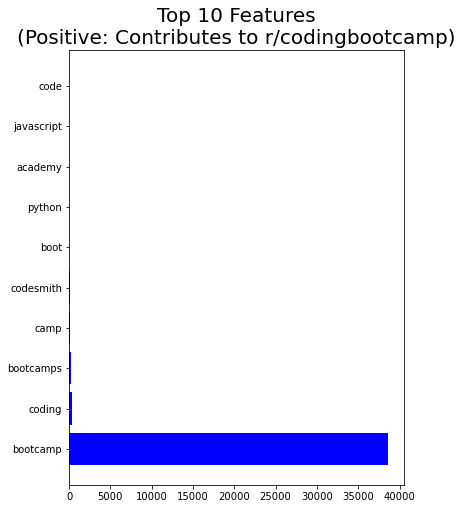

In [95]:
# Plotting top 10 features contributing to codingbootcamp
top_10_exp_df = exp_df.sort_values(by=0, ascending=False).head(10)
plot_df = top_10_exp_df
colors = ["r" if val < 0 else "b" for val in plot_df[0]]
plt.figure(figsize=(6,8))
plt.barh(y=plot_df.index, width=plot_df[0], color=colors)
plt.title(f"Top {10} Features" + "\n" + f"(Positive: Contributes to r/codingbootcamp)", fontsize=20)
top_10_exp_df

Text(0.5, 1.0, 'Top 10 Features\n(Positive: Contributes to r/codingbootcamp, exclude baseline keywords)')

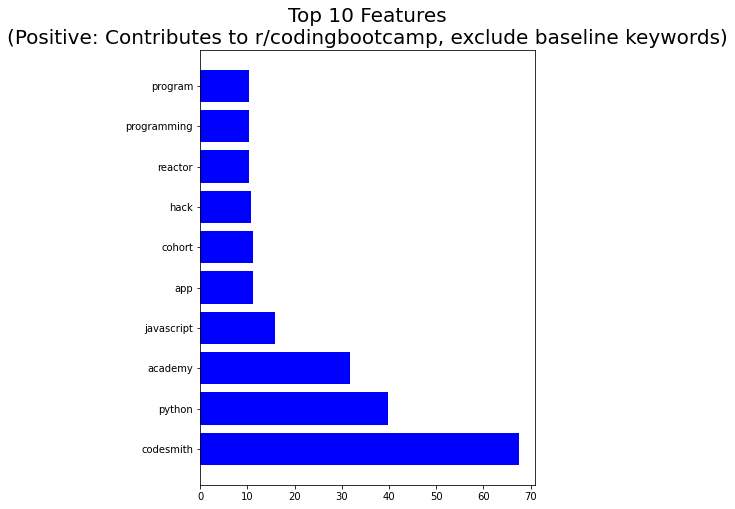

In [96]:
# Plotting top 10 features contributing to codingbootcamp, excluding code/camp/bootcamps/coding/bootcamp.
top_10_exclude = exp_df.drop(["bootcamp","bootcamps","boot","camp","coding","code"]).sort_values(by=0, ascending=False).head(10)
plot_df = top_10_exclude
colors = ["r" if val < 0 else "b" for val in plot_df[0]]
plt.figure(figsize=(6,8))
plt.barh(y=plot_df.index, width=plot_df[0], color=colors)
plt.title(f"Top {10} Features" + "\n" + f"(Positive: Contributes to r/codingbootcamp, exclude baseline keywords)", fontsize=20)

#### Comments on top features:
- Keywords such as "Python", "javascript", "programming", "program", appear as the top 10 keywords which contributes to the identification of whether a student is more likely to take on a bootcamp course.
- These keywords are technical skills related, and are areas that we can focus on in the courses offered at General Assembly.

## Moving forward:
- Data scraping to cover more online platforms that GA may be present in to refine our model. 
- Expand our model's outreach based on other GA courses, to potential students for UX/UI design as well.
- Better labelling and grouping to help the model better understand web lingo. For example, SWE appears often, but this is also a duplicate with software engineer, so potentially these terms could be grouped together for our model.
- Carry out sentiment analysis on comments to determine whether the user is positive or negative regarding the post. As the comments may also have some correlation to the possible conversion of the user.

## Conclusion & Recommendation

### Recommendations:
- GA marketing team to focus marketing efforts on showcasing how GA courses can equip a GA student with strong coding technical skills, as keywords with high correlation coefficient from the model, includes "Python", "javascript", "programming", "program", which suggests that people who are interested in joining boot camps, usually look out for courses that equip them with specific coding skillsets. 
- GA marketing team to help to identify more social media platforms (other than reddit) where the model can be deployed to identify potential students who want to join boot camps.

### Conclusion:
- Our model was ablee to achieve an accuracy of ~94% (>90%), beating the baseline model of ~79%, in terms of identifying potential candidates who are interested in coding boot camps.
- In order to maintain and further gain market shares with the rising competition from other boot camp course providers, it is key that GA needs to  act fast through the use of the model, to identify potential candidates.